In [17]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict
import matplotlib.ticker as ticker

from utils import *

In [18]:
# plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 25})

matplotlib.rc("xtick", labelsize=20)
matplotlib.rc("ytick", labelsize=20)

In [19]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Generalized Stitching Configs

In [20]:
def generalized_grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'gcdqn':
        result += 'GCDQN'
    elif config['agent']['agent_name'] == 'clearn_search':
        result += "C-LEARN"
    elif config['agent']['agent_name'] == 'gciql_search':
        result += "GCIQL"
    else:
        result += "CRL"

    if config['agent']['is_td']:
        result += ' TD'
    else:
        result += ' MC'

    if config['agent']['net_arch'] =='mlp':
        result += ' SMALL'
    else:
        result += ' BIG'


    return result

agents = ['GCDQN', 'C-LEARN', 'CRL', 'GCIQL']
grid_sizes = [5]

gamma = 0.9


for grid_size in grid_sizes:

    config_1 = {
        "directory": "generalized_gamma",
        "title": f"scaling_generalized_train_3_boxes_2_movable_{grid_size}_grid_gamma_{gamma}",
        "projects":["paper_generalized", "clearn_discount_check"],
        "possible_names":[' '.join([agent, s]) for s in ['MC BIG', 'MC SMALL', 'TD BIG', 'TD SMALL'] for agent in agents],
        "filters":{
            # "config.agent.is_td": False,
            "config.env.grid_size": grid_size,
            "config.env.number_of_boxes_max":3,
            "config.env.number_of_moving_boxes_max":2,
            "config.exp.gamma": gamma,
            "config.agent.discount": gamma,
        },
        "grouping_func": generalized_grouping_func,
        "metrics": OrderedDict([
            ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
        ]),
    }

    config_2 = {
        "directory": "generalized_gamma",
        "title": f"scaling_generalized_test_3_boxes_2_movable_{grid_size}_grid_gamma_{gamma}",
        "projects":["paper_generalized", "clearn_discount_check"],
        "possible_names":[' '.join([agent, s]) for s in ['MC BIG', 'MC SMALL', 'TD BIG', 'TD SMALL'] for agent in agents],
        "filters":{
            # "config.agent.is_td": False,
            "config.env.grid_size": grid_size,
            "config.env.number_of_boxes_max":3,
            "config.env.number_of_moving_boxes_max":2,
            "config.exp.gamma": gamma,
            "config.agent.discount": gamma,
        },
        "grouping_func": generalized_grouping_func,
        "metrics": OrderedDict([
            ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
        ]),
    }

    all_configs.extend([config_1, config_2])


# Plotting

128
128
./figures
./figures/generalized_gamma


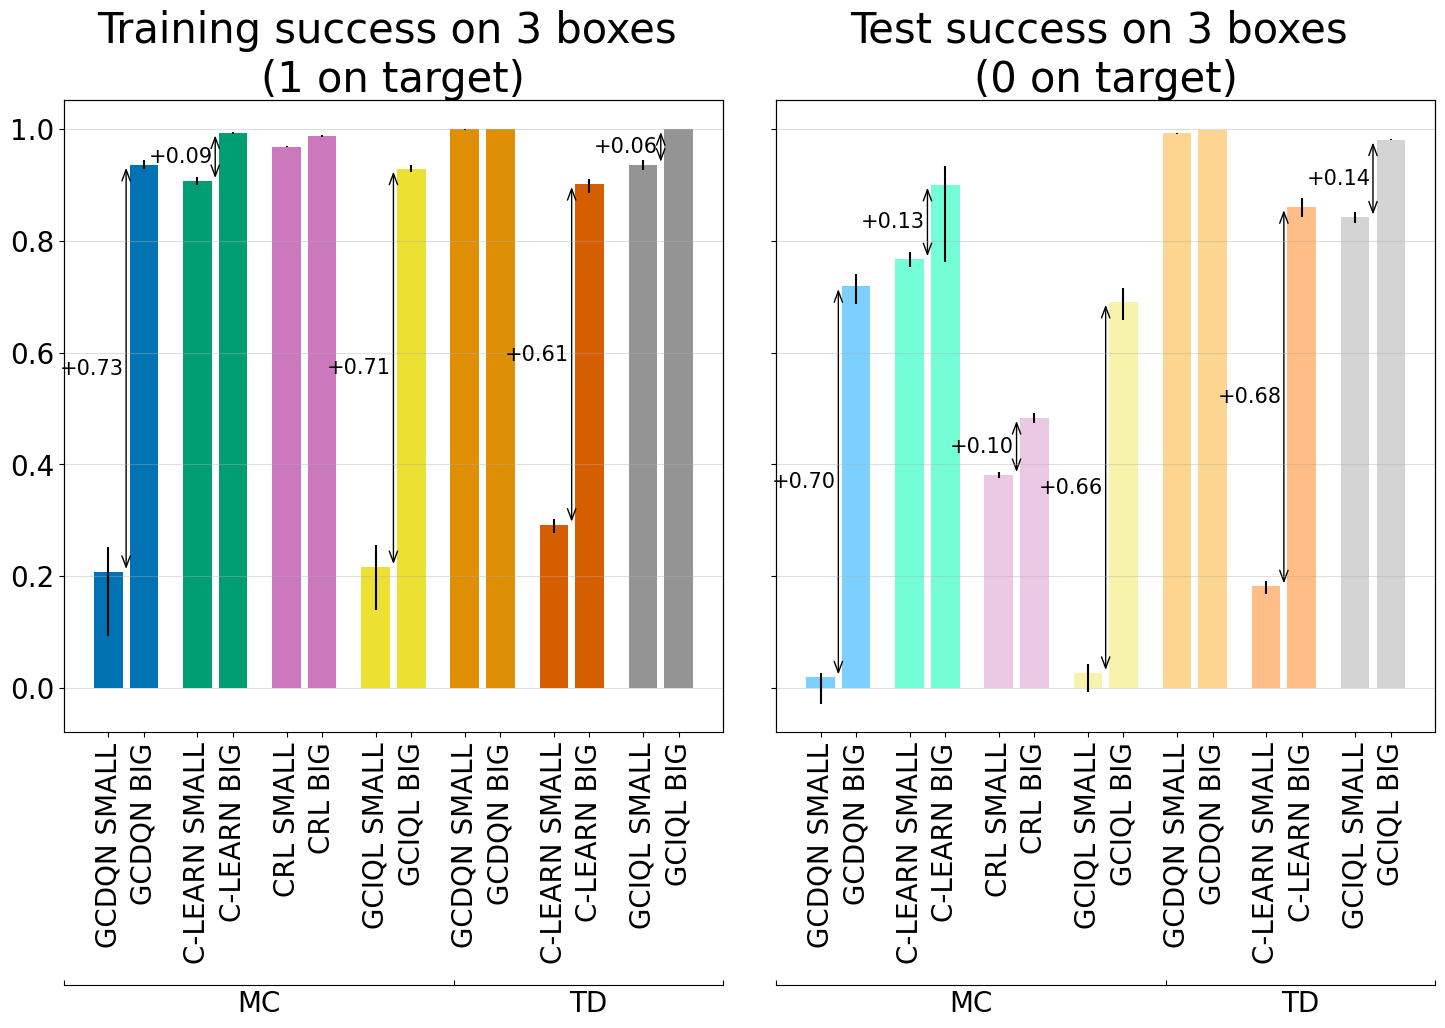

In [21]:
fig, axs = plt.subplots(1 ,2, figsize=(15, 12), sharey=True)


for config, ax in zip(all_configs, axs):
    ax.set_title(next(iter(config['metrics'].values())))
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])

    print(len(runs))
    # data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        new_data[k] = aggregated_v[:].reshape(-1, 1)
        # new_data[k + ' train'] = aggregated_v[:, 0].reshape(-1, 1)

    keys_to_del = []


    for k in keys_to_del:
        del new_data[k]


    names = list(new_data.keys())

    metrics_names = config['metrics']

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    aggregate_func = lambda x: np.array([metrics.aggregate_iqm(x[:, i]) for i in range(x.shape[-1])])


    # fig, ax = plt.subplots()
    aggregate_scores, aggregate_scores_cis = rly.get_interval_estimates(
        new_data, aggregate_func, reps=500
    )

    actual_keys = [k for k in aggregate_scores.keys() if 'BIG' not in k]

    color_palette = sns.color_palette('colorblind')
    color = color_palette[0 if 'train' in config['title'] else -1]

    tick_pos = []
    tick_labels = []
    ax.grid(True, axis='y', alpha=0.40)

    for idx, alg in enumerate(actual_keys):
        small_score = aggregate_scores[alg]
        small_cis = aggregate_scores_cis[alg]
        small_lower, small_upper = small_cis

        big_key = alg.replace('SMALL', 'BIG')
        big_score = aggregate_scores[big_key]
        big_cis = aggregate_scores_cis[big_key]
        big_lower, big_upper = big_cis

        center = 2.5 * idx + 0.5

        tick_pos.extend([center-0.5, center+0.5])
        label_name = alg.replace('SMALL', '')
        label_name = label_name.replace(' MC', '')
        label_name = label_name.replace(' TD', '')

        tick_labels.extend([label_name + 'SMALL', label_name + 'BIG'])
        color=return_color(alg, train='train' in config['title'])
        ax.bar(center + 0.5, big_score, yerr=(big_score - big_lower, big_upper - big_score), color=color)
        ax.bar(center - 0.5, small_score, yerr=(small_upper - small_score, small_score - small_lower), color=color)


        diff = (big_score - small_score).item()

        if abs(diff) > 0.05:

            upper_pt = (float(center), min(small_score.item(), big_score.item()))
            lower_pt = (float(center), max(small_score.item(), big_score.item()))
            arr = mpatches.FancyArrowPatch(lower_pt, upper_pt,
                                arrowstyle='<->,head_width=.15', mutation_scale=20)
            ax.add_patch(arr)
            sgn = '+' if diff > 0 else ''
            ax.annotate(f"{sgn}{diff:.2f}", (.2, .5), xycoords=arr, ha='right', va='center', fontsize=15)

        if big_score <= 0.01:
            ax.hlines(0, xmin=center - 0.9, xmax=center-0.1, color=color)

        if small_score <= 0.01:
            ax.hlines(0, xmin=center - 0.9, xmax=center-0.1, color=color)
    ax.set_xticks(tick_pos,  tick_labels, rotation=90)
    ax.set_yticks(np.arange(0, 1.1, 0.2))

    # ax2 = ax.twiny()
    # ax2.spines["bottom"].set_position(("axes", -0.10))
    # ax2.tick_params('both', length=0, width=0, which='minor')
    # ax2.tick_params('both', direction='in', which='major')
    # ax2.xaxis.set_ticks_position("bottom")
    # ax2.xaxis.set_label_position("bottom")
    # ax2.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # ax2.xaxis.set_major_formatter(ticker.NullFormatter())
    # ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8, 0.1]))
    # ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['GCDQN', 'C-LEARN', 'CRL', 'GCDQN', 'C-LEARN']))

    ax3 = ax.twiny()
    ax3.spines["bottom"].set_position(("axes", -0.40))
    ax3.tick_params('both', length=0, width=0, which='minor')
    ax3.tick_params('both', direction='in', which='major')
    ax3.xaxis.set_ticks_position("bottom")
    ax3.xaxis.set_label_position("bottom")
    middle_tick = 0.592
    ax3.set_xticks([0.0, middle_tick, 1.0])
    ax3.xaxis.set_major_formatter(ticker.NullFormatter())
    ax3.xaxis.set_minor_locator(ticker.FixedLocator([middle_tick / 2, middle_tick + (1 - middle_tick) / 2]))
    ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['MC', 'TD']))

    
title = all_configs[0]['title']
print(figures_path)
path = os.path.join(figures_path, 'generalized_gamma')
plt.tight_layout()
os.makedirs(path, exist_ok=True)
print(path)
plt.savefig(os.path.join(path, f"{title}.png"),bbox_inches='tight')
plt.savefig(os.path.join(path, f"{title}.pdf"),bbox_inches='tight')

    